RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41164D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.33578D+00    |proj g|=  2.09321D-01

At iterate    2    f=  3.29237D+00    |proj g|=  8.27826D-02

At iterate    3    f=  3.28716D+00    |proj g|=  5.33863D-02

At iterate    4    f=  3.28687D+00    |proj g|=  1.17759D-01

At iterate    5    f=  3.28639D+00    |proj g|=  1.41237D-02

At iterate    6    f=  3.28630D+00    |proj g|=  8.16716D-03

At iterate    7    f=  3.28619D+00    |proj g|=  3.61413D-03

At iterate    8    f=  3.28610D+00    |proj g|=  4.61493D-03

At iterate    9    f=  3.28572D+00    |proj g|=  1.52221D-02

At iterate   10    f=  3.28502D+00    |proj g|=  2.63795D-02

At iterate   11    f=  3.28352D+00    |proj g|=  3.94127D-02

At iterate   12    f=  3.28127D+00    |proj g|=  5.68943D-02

At iterate   13    f=  3.2

12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing


At iterate   94    f=  3.21179D+00    |proj g|=  4.99023D-04

At iterate   95    f=  3.21179D+00    |proj g|=  2.39808D-04

At iterate   96    f=  3.21179D+00    |proj g|=  1.05915D-04

At iterate   97    f=  3.21179D+00    |proj g|=  3.13616D-04

At iterate   98    f=  3.21179D+00    |proj g|=  4.81615D-04

At iterate   99    f=  3.21179D+00    |proj g|=  3.26672D-04

At iterate  100    f=  3.21179D+00    |proj g|=  1.67555D-04

At iterate  101    f=  3.21179D+00    |proj g|=  6.77014D-04

At iterate  102    f=  3.21179D+00    |proj g|=  4.71179D-04

At iterate  103    f=  3.21179D+00    |proj g|=  4.74598D-04

At iterate  104    f=  3.21179D+00    |proj g|=  1.54188D-04

At iterate  105    f=  3.21178D+00    |proj g|=  1.73368D-03

At iterate  106    f=  3.21178D+00    |proj g|=  9.76330D-04

At iterate  107    f=  3.21178D+00    |proj g|=  6.39533D-04

At iterate  108    f=  3.21178D+00    |proj g|=  3.72724D-04

At iterate  109    f=  3.21178D+00    |proj g|=  4.81437D-04

At itera

Accuracy - MAE - ARIMA: 6.797952477048793  
Accuracy - Adaboost: 98.59503450566216 %
Accuracy - ETS: 0 %
Accuracy - Prophet: 98.13390298335634 %
Accuracy - LightGBM: 97.55224152558925 %
Accuracy - ARIMA: 97.35266816963353 %


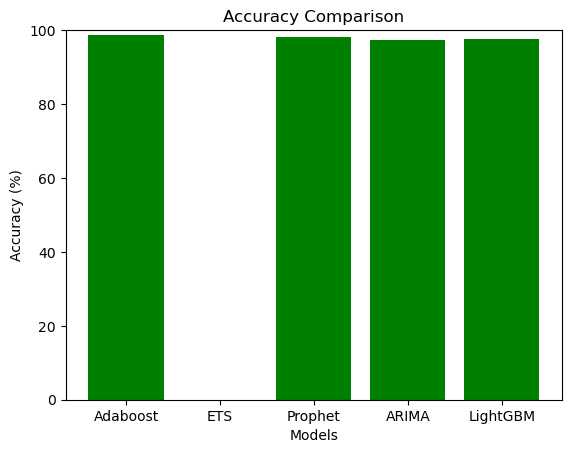

In [21]:
import numpy as np
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Load your data into a DataFrame
data = pd.read_csv('Global_sea_level_rise.csv')
data = data[['date', 'sealevel']]  # Corrected column name
data = data.dropna()

# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Calculate the range of the target variable
y_range = data['sealevel'].max() - data['sealevel'].min()

# Initialize the models
adaboost_model = AdaBoostRegressor(n_estimators=100, random_state=0)
ets_model = ETSModel(data['sealevel'], error='add', trend='add', seasonal='add', seasonal_periods=12)
prophet_model = Prophet(yearly_seasonality=True)
#sarima_model = SARIMAX(data['sealevel'], order=(0,0,0), seasonal_order=(0,0,0,0)) # no seasonality in dataset
lgbm_model = LGBMRegressor()

arima_model = ARIMA(data['sealevel'], order=(1,1,1))  # ARIMA(p, d, q), where d=1 for first differencing


# Fit the models
adaboost_model.fit(data[['date']], data['sealevel'])
ets_fit = ets_model.fit()
prophet_model.fit(data.rename(columns={'date': 'ds', 'sealevel': 'y'}))  # Rename columns for Prophet
#sarima_fit = sarima_model.fit(disp=False)
lgbm_model.fit(data.index.values.reshape(-1, 1), data['sealevel'])

arima_fit = arima_model.fit()

# Make predictions
adaboost_pred = adaboost_model.predict(data[['date']])
ets_pred = ets_fit.forecast(steps=len(data))
prophet_pred = prophet_model.predict(data.rename(columns={'date': 'ds'}))
#sarima_pred = sarima_fit.get_forecast(steps=len(data)).predicted_mean
lgbm_pred = lgbm_model.predict(data.index.values.reshape(-1, 1))

arima_pred = arima_fit.predict(typ='levels')

# Calculate Mean Absolute Error for each model
mae_adaboost = mean_absolute_error(data['sealevel'], adaboost_pred)
mae_ets = mean_absolute_error(data['sealevel'], ets_pred)
mae_prophet = mean_absolute_error(data['sealevel'], prophet_pred['yhat'].values)
#mae_sarima = mean_absolute_error(data['sealevel'], sarima_pred)
mae_lgbm = mean_absolute_error(data['sealevel'], lgbm_pred)

mae_arima = mean_absolute_error(data['sealevel'], arima_pred)
# Calculate Accuracy (%)
accuracy_adaboost = (1 - mae_adaboost / y_range) * 100
accuracy_ets = (1 - mae_ets / y_range) * 100 if mae_ets <= y_range else 0
accuracy_prophet = (1 - mae_prophet / y_range) * 100
#accuracy_sarima = (1 - mae_sarima / y_range) * 100 if mae_sarima <= y_range else 0
accuracy_lgbm = (1 - mae_lgbm / y_range) * 100


accuracy_arima = (1 - mae_arima / y_range) * 100
print("Accuracy - MAE - ARIMA:", mae_arima, " ")


# Print Accuracy
print("Accuracy - Adaboost:", accuracy_adaboost, "%")
print("Accuracy - ETS:", accuracy_ets, "%")
print("Accuracy - Prophet:", accuracy_prophet, "%")
#print("Accuracy - SARIMA:", accuracy_sarima, "%")
print("Accuracy - LightGBM:", accuracy_lgbm, "%")

print("Accuracy - ARIMA:", accuracy_arima, "%")

# Visualization
models = ['Adaboost', 'ETS', 'Prophet', 'ARIMA', 'LightGBM']
accuracies = [accuracy_adaboost, accuracy_ets, accuracy_prophet, accuracy_arima, accuracy_lgbm]

plt.bar(models, accuracies, color='green')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.ylim(0, 100)  # Set y-axis limit to 0-100
plt.show()


/tmp/ipykernel_1521098/1970969719.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


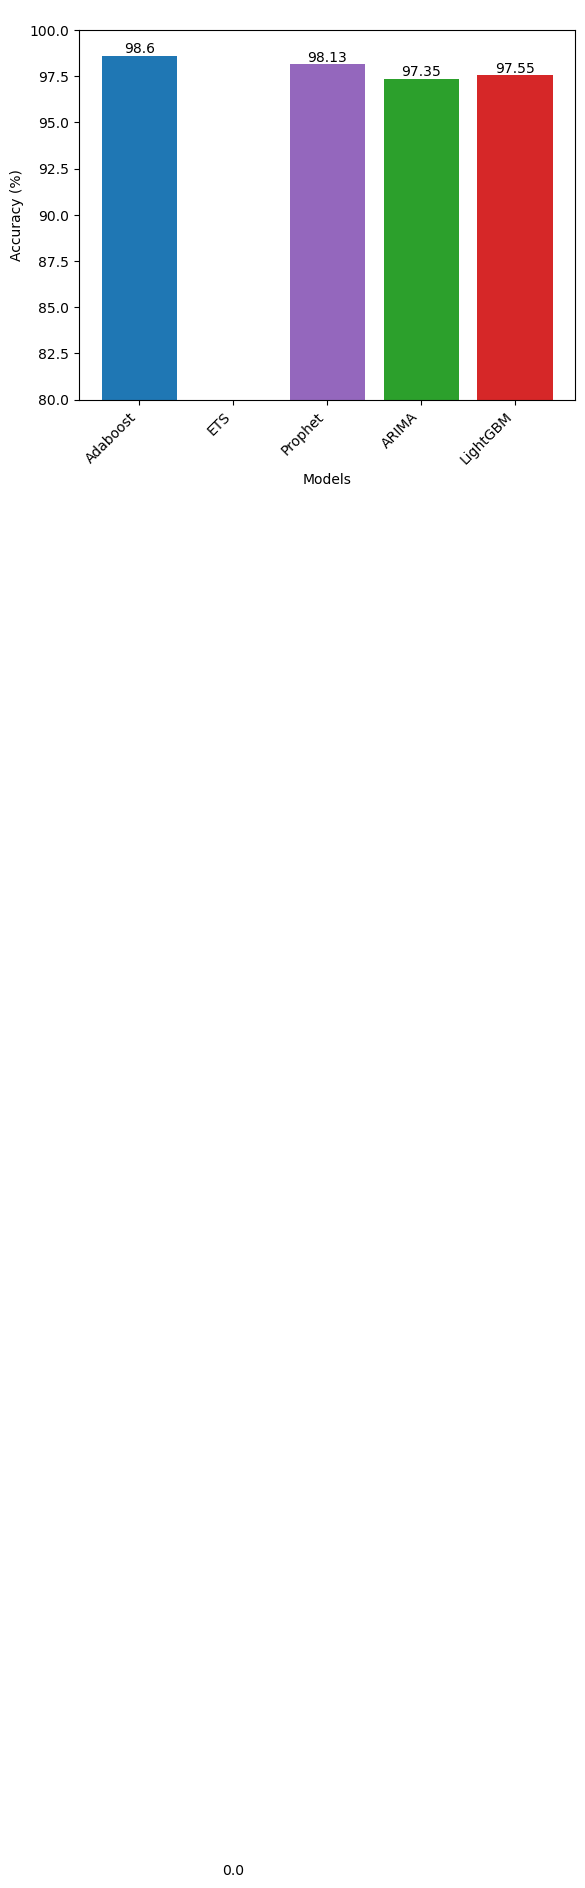

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

models = ['Adaboost', 'ETS', 'Prophet', 'ARIMA', 'LightGBM']
accuracy_scores = [98.59503450566216, 0, 98.13390298335634, 97.35, 97.55224152558925]
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#2ca02c', '#d62728']


# Create a figure and axis
fig, ax = plt.subplots()

# Set the colors for each bar
bars = ax.bar(models, accuracy_scores, color=colors)

# Set the title and labels
ax.set_title(' ')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha="right")

# Set the y-axis limits to focus on the top part
plt.ylim(80, 100)

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')
plt.savefig('airquality.eps', format='eps', bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()
# Export the plot as an EPS file
plt.savefig('sealevel.eps', format='eps', bbox_inches='tight')




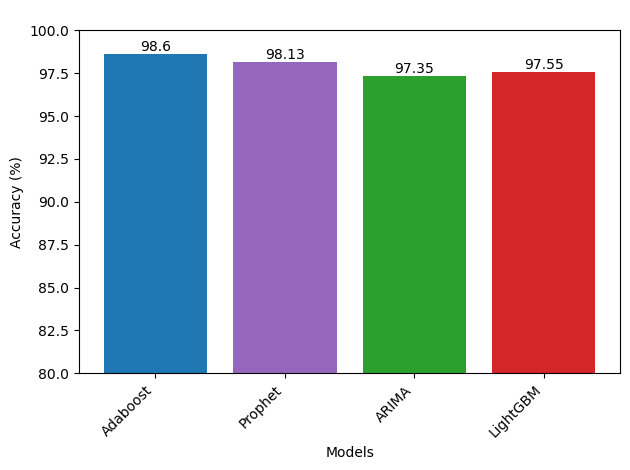

In [9]:
import matplotlib.pyplot as plt

models = ['Adaboost', 'Prophet', 'ARIMA', 'LightGBM']
accuracy_scores = [98.59503450566216, 98.13390298335634, 97.35, 97.55224152558925]
colors = ['#1f77b4', '#9467bd', '#2ca02c', '#d62728']

# Convert zero accuracy scores to a small non-zero value for y-axis
accuracy_scores = [score if score != 0 else 0.01 for score in accuracy_scores]

# Create a figure and axis
fig, ax = plt.subplots()

# Set the colors for each bar
bars = ax.bar(models, accuracy_scores, color=colors)

# Set the title and labels
ax.set_title(' ')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha="right")

# Set the y-axis limits to focus on the top part
plt.ylim(80, 100)

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')

# Save the plot as an EPS file
plt.savefig('sealevel.eps', format='eps', bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()
